In [41]:
import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from datetime import datetime, timedelta

In [42]:
api_key = '2f0fdd5d49254c06b7dc54cc45a4b628'
symbol = 'BTC/USD'
interval = '5min'
order = 'asc'
start_date =  datetime.strftime(datetime.now() - timedelta(20),'%Y-%m-%d %H:%M:%S')
end_date = datetime.strftime(datetime.now() - timedelta(3),'%Y-%m-%d %H:%M:%S')

api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={start_date}&end_date={end_date}&interval={interval}&order={order}&apikey={api_key}'

In [43]:
data = requests.get(api_url).json()
data_final = pd.DataFrame(data['values'])
data_final

,datetime,open,high,low,close
0,2022-06-29 18:45:00,20046.90039,20046.90039,20013.55078,20034.14062
1,2022-06-29 18:50:00,20035.43945,20065.59961,20027.03906,20041.80078
2,2022-06-29 18:55:00,20042.40039,20060.35938,20026.28906,20034.94922
3,2022-06-29 19:00:00,20026.28906,20041.60938,20010.19922,20026.91992
4,2022-06-29 19:05:00,20021.60938,20072.55078,20014.50977,20067.26953
...,...,...,...,...,...
4891,2022-07-16 18:20:00,21269.63086,21333.00000,21265.40039,21321.05078
4892,2022-07-16 18:25:00,21311.66016,21321.05078,21276.33984,21299.10938
4893,2022-07-16 18:30:00,21276.33984,21299.10938,21220.00000,21220.00000
4894,2022-07-16 18:35:00,21224.00977,21276.91992,21194.56055,21263.30078


In [44]:
data_final.describe()

,datetime,open,high,low,close
count,4896,4896,4896,4896,4896
unique,4896,4848,4635,4623,4835
top,2022-06-29 18:45:00,21691.66992,20136.73047,19251.00000,20275.88086
freq,1,3,3,3,2


In [45]:
data.keys()

dict_keys(['meta', 'values', 'status'])

In [46]:
#RANGE CONVERSION
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_final['close'].values.reshape(-1,1))

In [47]:
scaled_data.shape #UD

(4896, 1)

In [48]:
data_final['close'].values # UD

array(['20034.14062', '20041.80078', '20034.94922', ..., '21220.00000',
       '21263.30078', '21244.00977'], dtype=object)

In [49]:
data_final['close'].values.reshape(-1,1) #UD

array([['20034.14062'],
       ['20041.80078'],
       ['20034.94922'],
       ...,
       ['21220.00000'],
       ['21263.30078'],
       ['21244.00977']], dtype=object)

In [50]:
scaled_data

array([[0.37787289],
       [0.37999587],
       [0.37809699],
       ...,
       [0.70652956],
       [0.71853021],
       [0.71318378]])

In [51]:
time_intervals_to_train = 24
prediction_interval = 12

x_train = []
y_train = []

In [52]:
#data prepration
for i in range(time_intervals_to_train, len(scaled_data) - prediction_interval):
    x_train.append(scaled_data[i - time_intervals_to_train: i, 0])
    y_train.append(scaled_data[i + prediction_interval, 0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [53]:
x_train.shape #UD

(4860, 24)

In [54]:
y_train.shape #UD

(4860,)

In [55]:
x_train #UD

array([[0.37787289, 0.37999587, 0.37809699, ..., 0.42127932, 0.3970983 ,
        0.39861178],
       [0.37999587, 0.37809699, 0.3758717 , ..., 0.3970983 , 0.39861178,
        0.4077549 ],
       [0.37809699, 0.3758717 , 0.38705445, ..., 0.39861178, 0.4077549 ,
        0.39887485],
       ...,
       [0.61856047, 0.61531212, 0.61748545, ..., 0.78023968, 0.79510274,
        0.774569  ],
       [0.61531212, 0.61748545, 0.62198583, ..., 0.79510274, 0.774569  ,
        0.76275401],
       [0.61748545, 0.62198583, 0.62728517, ..., 0.774569  , 0.76275401,
        0.76329748]])

In [56]:
y_train #UD

array([0.44689859, 0.44118948, 0.44480916, ..., 0.70652956, 0.71853021,
       0.71318378])

In [57]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [58]:
x_train.shape 

(4860, 24, 1)

In [59]:
model = Sequential()
model.add(LSTM(128, return_sequences= True, input_shape = (x_train.shape[1], 1), activation='relu'))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences= True, activation ='relu'))
model.add(Dropout(0.3))
model.add(LSTM(32, activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation ='sigmoid'))
          
          
model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['accuracy'])

In [60]:
 model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
76/76 [==============================] - 7s 52ms/step - loss: 0.0203 - accuracy: 4.1152e-04
Epoch 2/10
76/76 [==============================] - 4s 54ms/step - loss: 0.0048 - accuracy: 4.1152e-04
Epoch 3/10
76/76 [==============================] - 4s 54ms/step - loss: 0.0045 - accuracy: 4.1152e-04
Epoch 4/10
76/76 [==============================] - 4s 56ms/step - loss: 0.0042 - accuracy: 4.1152e-04
Epoch 5/10
76/76 [==============================] - 4s 55ms/step - loss: 0.0043 - accuracy: 4.1152e-04
Epoch 6/10
76/76 [==============================] - 4s 56ms/step - loss: 0.0041 - accuracy: 4.1152e-04
Epoch 7/10
76/76 [==============================] - 4s 57ms/step - loss: 0.0038 - accuracy: 4.1152e-04
Epoch 8/10
76/76 [==============================] - 5s 59ms/step - loss: 0.0037 - accuracy: 4.1152e-04
Epoch 9/10
76/76 [==============================] - 5s 60ms/step - loss: 0.0036 - accuracy: 4.1152e-04
Epoch 10/10
76/76 [==============================] - 5s 59ms/step - loss:

In [61]:
model.save('Cryptocurrency_predictor.h5')

test_start =datetime.strftime(datetime.now() - timedelta(3),'%Y-%m-%d %H:%M:%S')
now= datetime.now()
test_end = now.strftime("%Y-%m-%d %H:%M:%S")

test_api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={test_start}&end_date={test_end}&interval={interval}&order={order}&apikey={api_key}'
test_data = requests.get(test_api_url).json()
test_data_final = pd.DataFrame(test_data['values'])
test_data_final

,datetime,open,high,low,close
0,2022-07-16 18:45:00,21239.14062,21263.68945,21226.99023,21231.90039
1,2022-07-16 18:50:00,21227.14062,21265.89062,21196.52930,21263.31055
2,2022-07-16 18:55:00,21265.89062,21290.00977,21263.31055,21290.00977
3,2022-07-16 19:00:00,21285.36914,21317.36914,21284.43945,21301.09961
4,2022-07-16 19:05:00,21308.93945,21313.35938,21282.00000,21302.24023
...,...,...,...,...,...
793,2022-07-19 12:50:00,22180.35938,22192.16992,22131.03906,22185.00977
794,2022-07-19 12:55:00,22186.00977,22192.16992,22167.09961,22180.91016
795,2022-07-19 13:00:00,22180.28906,22196.71094,22133.96094,22133.96094
796,2022-07-19 13:05:00,22124.65039,22169.38086,22124.65039,22154.91016


In [62]:
bitcoin_prices =pd.to_numeric(test_data_final['close'], errors ='coerce').values # to float

test_inputs = test_data_final['close'].values
test_inputs = test_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(test_inputs)

In [82]:
bitcoin_prices.shape

(798,)

In [83]:
bitcoin_prices

array([21231.90039, 21263.31055, 21290.00977, 21301.09961, 21302.24023,
       21341.48047, 21352.91016, 21299.2793 , 21306.9707 , 21303.05078,
       21262.50977, 21249.99023, 21195.10938, 21179.90039, 21190.78906,
       21202.24023, 21181.11914, 21059.26953, 21017.93945, 20953.75   ,
       20962.9707 , 21021.89062, 21084.63086, 21119.66016, 21115.7793 ,
       21130.78906, 21188.15039, 21176.00977, 21147.82031, 21138.99023,
       21096.44922, 21157.18945, 21314.74023, 21260.60938, 21233.36914,
       21260.86914, 21286.32031, 21241.74023, 21188.33984, 21157.78906,
       21175.83008, 21186.2793 , 21201.25977, 21196.91016, 21227.25   ,
       21214.28906, 21211.91992, 21235.5293 , 21253.89062, 21259.43945,
       21293.91992, 21278.46094, 21250.38086, 21232.84961, 21193.07031,
       21193.69922, 21175.86914, 21192.98047, 21177.26953, 21179.5293 ,
       21216.08008, 21189.74023, 21205.82031, 21225.36914, 21290.17969,
       21333.75   , 21279.7207 , 21226.41992, 21248.16992, 21262

In [63]:
model_inputs.shape

(798, 1)

In [64]:
x_test= []

for x in range(time_intervals_to_train, len(model_inputs)):
    x_test.append(model_inputs[x - time_intervals_to_train: x, 0])

    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [65]:
x_test.shape #UD

(774, 24, 1)

In [81]:
x_test

array([[[0.22273349],
        [0.23776207],
        [0.25053664],
        ...,
        [0.12225176],
        [0.15227059],
        [0.16903079]],

       [[0.23776207],
        [0.25053664],
        [0.25584271],
        ...,
        [0.15227059],
        [0.16903079],
        [0.16717394]],

       [[0.25053664],
        [0.25584271],
        [0.25638845],
        ...,
        [0.16903079],
        [0.16717394],
        [0.17435555]],

       ...,

       [[0.58912059],
        [0.60066069],
        [0.62882828],
        ...,
        [0.67534938],
        [0.6787603 ],
        [0.67679879]],

       [[0.60066069],
        [0.62882828],
        [0.63091408],
        ...,
        [0.6787603 ],
        [0.67679879],
        [0.65433536]],

       [[0.62882828],
        [0.63091408],
        [0.64644074],
        ...,
        [0.67679879],
        [0.65433536],
        [0.66435877]]])

In [66]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

25/25 [==============================] - 1s 12ms/step


In [67]:
prediction_prices.shape

(774, 1)

In [68]:
prediction_prices #UD

array([[21088.97 ],
       [21070.373],
       [21056.037],
       [21047.062],
       [21043.195],
       [21043.361],
       [21046.203],
       [21050.256],
       [21055.422],
       [21063.113],
       [21073.035],
       [21084.71 ],
       [21098.293],
       [21113.592],
       [21129.809],
       [21144.68 ],
       [21156.133],
       [21163.639],
       [21167.16 ],
       [21169.143],
       [21168.926],
       [21166.684],
       [21162.98 ],
       [21158.568],
       [21154.426],
       [21151.383],
       [21150.426],
       [21152.576],
       [21157.807],
       [21165.277],
       [21173.533],
       [21180.488],
       [21185.38 ],
       [21188.23 ],
       [21188.27 ],
       [21185.389],
       [21180.133],
       [21173.588],
       [21165.791],
       [21157.533],
       [21149.88 ],
       [21144.959],
       [21144.248],
       [21147.627],
       [21153.865],
       [21162.252],
       [21172.123],
       [21182.658],
       [21193.55 ],
       [21204.42 ],


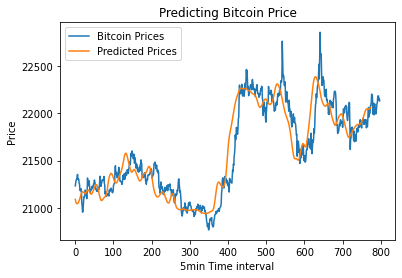

In [69]:
plt.plot(bitcoin_prices, label ='Bitcoin Prices')
plt.plot(prediction_prices, label = 'Predicted Prices')
plt.title('Predicting Bitcoin Price')
plt.xlabel('5min Time interval')
plt.ylabel('Price')
plt.legend()
plt.show()

In [70]:
len(model_inputs)

798

In [71]:
time_intervals_to_train

24

In [72]:
model_inputs

array([[0.22273349],
       [0.23776207],
       [0.25053664],
       [0.25584271],
       [0.25638845],
       [0.27516342],
       [0.28063209],
       [0.25497176],
       [0.2586518 ],
       [0.25677627],
       [0.23737893],
       [0.2313888 ],
       [0.20513039],
       [0.19785346],
       [0.20306328],
       [0.20854223],
       [0.19843659],
       [0.14013616],
       [0.12036127],
       [0.08964905],
       [0.09406081],
       [0.12225176],
       [0.15227059],
       [0.16903079],
       [0.16717394],
       [0.17435555],
       [0.20180077],
       [0.19599195],
       [0.18250436],
       [0.1782795 ],
       [0.15792523],
       [0.18698713],
       [0.26236923],
       [0.23646966],
       [0.22343624],
       [0.23659395],
       [0.24877137],
       [0.22744149],
       [0.20189142],
       [0.18727403],
       [0.19590597],
       [0.20090553],
       [0.20807312],
       [0.20599199],
       [0.22050846],
       [0.21430714],
       [0.2131736 ],
       [0.224

In [73]:
#forecast price for the next hour
last_data = model_inputs[len(model_inputs) - time_intervals_to_train: len(model_inputs), 0]
last_data = np.array(last_data)

In [74]:
last_data.shape #UD

(24,)

In [75]:
last_data = np.reshape(last_data, (1, last_data.shape[0], 1))

In [76]:
last_data.shape

(1, 24, 1)

In [77]:
prediction = model.predict(last_data)

1/1 [==============================] - 0s 28ms/step


In [78]:
prediction = scaler.inverse_transform(prediction)

In [79]:
prediction

array([[22063.342]], dtype=float32)

In [80]:
prediction[0][0]

22063.342